In [118]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds
import pylab as plt
from scipy.linalg import svdvals

In [83]:
def load_mnist(datadir='./data_cache'):
    train_ds = ds.MNIST(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.MNIST(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = np.array(dataset.data) / 255.0  # [0, 1]
        Y = np.array(dataset.targets)
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

X_tr, Y_tr, X_te, Y_te = load_mnist()

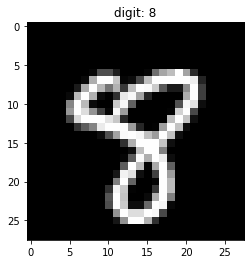

In [84]:
i = np.random.choice(len(X_tr))
plt.imshow(X_tr[i], cmap='gray');
plt.title(f'digit: {Y_tr[i]}');

## Linear Regression

In [100]:
print('original X_tr:', X_tr.shape)

# select 500 random examples
n = 500
I = np.random.choice(len(X_tr), n, replace=False)
X = X_tr[I]
Y = (Y_tr[I] % 2) * 2.0 - 1 # odd/even --> +1/-1
X = X.reshape(-1,  28*28) # flatten

print('reshaped X:', X.shape)
print('reshaped Y:', Y.shape)

original X_tr: (60000, 28, 28)
reshaped X: (500, 784)
reshaped Y: (500,)


In [101]:
np.linalg.matrix_rank(X)

500

In [102]:
beta = np.matmul(np.linalg.pinv(X), Y)
np.allclose(np.matmul(X, beta), Y)

True

In [103]:
# Now finding how much error our linear regression weight beta has on the test set
# First, set up test set:

X_te_mod = X_te.reshape(-1, 28*28)
Y_te_mod = (Y_te % 2) * 2.0 - 1

In [104]:
# Now, we compute MSE on this test set:
def mse(beta, X, Y):
    return np.mean(np.square(np.matmul(X, beta) - Y))

mse(beta, X_te_mod, Y_te_mod)

10.67009086229678

In [105]:
mses = []
for _ in range(20):
    n = 500
    I = np.random.choice(len(X_tr), n, replace=False)
    X_temp = X_tr[I]
    Y_temp = (Y_tr[I] % 2) * 2.0 - 1 # odd/even --> +1/-1
    X_temp = X_temp.reshape(-1,  28*28) # flatten
    
    beta = np.matmul(np.linalg.pinv(X_temp), Y_temp)
    mses.append(mse(beta, X_te_mod, Y_te_mod))

print(f'20 Trials Average MSE: {np.mean(mses)}')

20 Trials Average MSE: 15.219902966695926


In [28]:
def accuracy(beta, X, Y):
    return np.mean(1 - (np.abs(np.where(np.matmul(X, beta) > 0, 1, -1) - Y) / 2))

accuracy(beta, X_te_mod, Y_te_mod)

0.58

In [72]:
def gradient(beta, X, Y):
    return 2 * np.matmul(X.T, np.matmul(X, beta) - Y)

def stochastic_gradient(beta, X, Y, batch_size=1):
    I = np.random.choice(len(X), batch_size, replace=False)
    temp_X = X[I]
    temp_Y = Y[I]
    return gradient(beta, X, Y)

In [80]:
def gd(X, Y, lr=0.00003, epochs=1000, epochs_per_print=20, low=-.1, high=.1, X_te=None, Y_te=None):
    gen = np.random.default_rng()
    beta = gen.uniform(low=low, high=high, size=784)
    for i in range(epochs):
        beta -= lr * gradient(beta, X, Y)
        if i % epochs_per_print == 0 or (i % 100 == 0 and i <= 2000): 
            tr_loss = mse(beta, X, Y)
            tr_acc = accuracy(beta, X, Y)
            print(f'Epoch {i}', f"Train Accuracy: {tr_acc:.3f}", f'Training Loss: {tr_loss:.3f}', sep='\t', end='')
            if X_te is not None and Y_te is not None:
                te_acc = accuracy(beta, X_te, Y_te)
                print(f"\tTest Accuracy: {te_acc:.3f}")
            else:
                print()
    return beta

def sgd(X, Y, lr=0.00003, epochs=1000, epochs_per_print=20, low=-.1, high=.1, X_te=None, Y_te=None, batch_size=1):
    gen = np.random.default_rng()
    beta = gen.uniform(low=low, high=high, size=784)
    for i in range(epochs):
        beta -= lr * stochastic_gradient(beta, X, Y, batch_size=batch_size)
        if i % epochs_per_print == 0 or (i % 100 == 0 and i <= 2000): 
            tr_loss = mse(beta, X, Y)
            tr_acc = accuracy(beta, X, Y)
            print(f'Epoch {i}', f"Train Accuracy: {tr_acc:.3f}", f'Training Loss: {tr_loss:.3f}', sep='\t', end='')
            if X_te is not None and Y_te is not None:
                te_acc = accuracy(beta, X_te, Y_te)
                print(f"\tTest Accuracy: {te_acc:.3f}")
            else:
                print()
    return beta

In [74]:
beta_gd = gd(X, Y, epochs=100000, epochs_per_print=5000, X_te = X_te_mod, Y_te = Y_te_mod)

Epoch 0	Train Accuracy: 0.608	Training Loss: 0.912	Test Accuracy: 0.611
Epoch 100	Train Accuracy: 0.894	Training Loss: 0.381	Test Accuracy: 0.840
Epoch 200	Train Accuracy: 0.918	Training Loss: 0.337	Test Accuracy: 0.845
Epoch 300	Train Accuracy: 0.932	Training Loss: 0.309	Test Accuracy: 0.844
Epoch 400	Train Accuracy: 0.940	Training Loss: 0.290	Test Accuracy: 0.845
Epoch 500	Train Accuracy: 0.946	Training Loss: 0.274	Test Accuracy: 0.844
Epoch 600	Train Accuracy: 0.944	Training Loss: 0.262	Test Accuracy: 0.844
Epoch 700	Train Accuracy: 0.948	Training Loss: 0.251	Test Accuracy: 0.842
Epoch 800	Train Accuracy: 0.950	Training Loss: 0.242	Test Accuracy: 0.841
Epoch 900	Train Accuracy: 0.956	Training Loss: 0.234	Test Accuracy: 0.839
Epoch 1000	Train Accuracy: 0.960	Training Loss: 0.227	Test Accuracy: 0.838
Epoch 1100	Train Accuracy: 0.962	Training Loss: 0.221	Test Accuracy: 0.839
Epoch 1200	Train Accuracy: 0.962	Training Loss: 0.215	Test Accuracy: 0.839
Epoch 1300	Train Accuracy: 0.964	Trai

In [81]:
beta_sgd = sgd(X, Y, epochs=50000, epochs_per_print=5000, X_te = X_te_mod, Y_te = Y_te_mod, batch_size=1)

Epoch 0	Train Accuracy: 0.538	Training Loss: 1.064	Test Accuracy: 0.552
Epoch 100	Train Accuracy: 0.892	Training Loss: 0.380	Test Accuracy: 0.839
Epoch 200	Train Accuracy: 0.908	Training Loss: 0.332	Test Accuracy: 0.842
Epoch 300	Train Accuracy: 0.918	Training Loss: 0.305	Test Accuracy: 0.841
Epoch 400	Train Accuracy: 0.934	Training Loss: 0.285	Test Accuracy: 0.840
Epoch 500	Train Accuracy: 0.944	Training Loss: 0.270	Test Accuracy: 0.839
Epoch 600	Train Accuracy: 0.950	Training Loss: 0.257	Test Accuracy: 0.839
Epoch 700	Train Accuracy: 0.954	Training Loss: 0.246	Test Accuracy: 0.839
Epoch 800	Train Accuracy: 0.960	Training Loss: 0.237	Test Accuracy: 0.839
Epoch 900	Train Accuracy: 0.962	Training Loss: 0.229	Test Accuracy: 0.838
Epoch 1000	Train Accuracy: 0.962	Training Loss: 0.222	Test Accuracy: 0.837
Epoch 1100	Train Accuracy: 0.962	Training Loss: 0.216	Test Accuracy: 0.836
Epoch 1200	Train Accuracy: 0.968	Training Loss: 0.210	Test Accuracy: 0.836
Epoch 1300	Train Accuracy: 0.970	Trai

In [107]:
_, s, _ = np.linalg.svd(X)

In [113]:
print(f'Condition Number of X: {s.max() / s.min()}')

Condition Number of X: 7119.050088619612


In [120]:
svds = svdvals(X)
svds.max() / svds.min()

7119.050088619669